# Markov Chains


Начнем с небольшого упражнения по Марковским цепям. Пусть мы проводим ежедневные наблюдения за погодой и погода бывает одной из трех типов: солнечной, облачной или дождливой. Опишем все возможные состояния:

In [32]:
state_wheather = ("sunny", "cloudy", "rainy")

Пусть статистика многодневных наблюдений показывает, что вероятности перемены (или сохранения) состояния погоды опиcываются следующей мaтрицей переходных вероятностей:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

**Задание 1.** Выберите произвольное начальное состояние и смоделируйте 20000 последующих состояний в цепи Маркова с введенной выше матрицей переходов. Результат моделирования (массив размера 20000) запишите в переменную `states`.

In [68]:
states = np.full(20000, state_weather[1])
my_matrix = np.empty(shape = (3,3))

def rename(weather):
    if (weather == state_weather[0]):
        return 0
    elif (weather == state_weather[1]):
        return 1
    else:
        return 2

for i in range (3):
    for j in range(3):
        my_matrix[i,j] = np.sum(transition_matrix[i,:(j+1)])

a = np.random.rand()
if (a < 1/3):
    initial_weather = state_weather[0]
elif (a > 2/3):
    initial_weather = state_weather[2]
else:
    initial_weather = state_weather[1]

finite_weather = rename(initial_weather)

a = np.random.rand()
if (a < my_matrix[finite_weather, 0]):
    states[0] = initial_weather[0]
elif (a > my_matrix[finite_weather, 1]):
    states[0] = state_weather[2]
else:
    states[0] = state_weather[1]

for i in range (1, 20000):
    finite_weather = rename(states[i-1])
    
    a = np.random.rand()
    
    if (a < my_matrix[finite_weather, 0]):
        states[i] = state_weather[0]
    elif (a > my_matrix[finite_weather, 1]):
        states[i] = state_weather[2]
    else:
        states[i] = state_weather[1]
        
print(states)

['rainy' 'sunny' 'sunny' ... 'cloudy' 'cloudy' 'sunny']


---

**Задание 2.** На основе массива `states` рассчитайте, как меняется частота встречаемости каждого из типов погоды в массиве `states[:n]` для `n`, возрастающих от 1 до 20000. На одном рисунке покажите 3 графика: по оси х откладывайте `n`, по у - частоту для каждого из трех типов погоды. Должна получиться примерно следующая картинка:
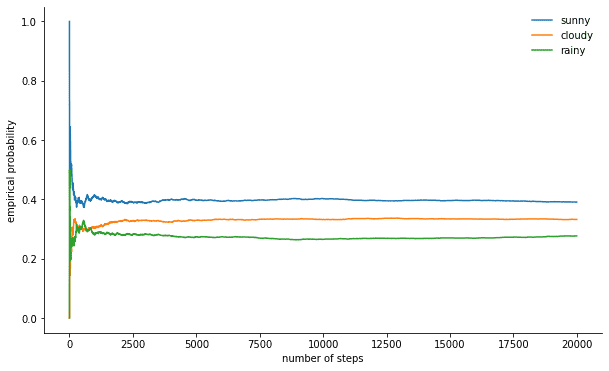

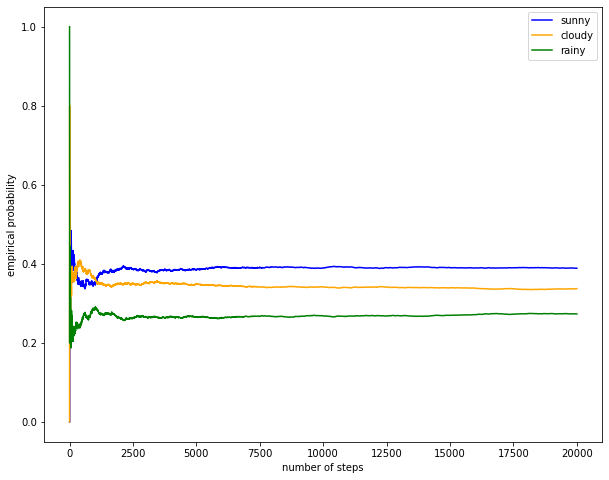

In [38]:
sunny = np.empty(20000, dtype = "float")
cloudy = np.empty(20000, dtype = "float")
rainy = np.empty(20000, dtype = "float")

for i in range (20000):
    sunny[i] = (np.count_nonzero(states[:(i+1)] == "sunny"))/(i+1)
    cloudy[i] = (np.count_nonzero(states[:(i+1)] == "cloudy"))/(i+1)
    rainy[i] = (np.count_nonzero(states[:(i+1)] == "rainy"))/(i+1)
    
X = np.array([j for j in range(20000)], dtype = "int")

plt.figure(figsize=(10, 8))

plt.plot(X, sunny, c = "blue", label = "sunny")
plt.plot(X, cloudy, c = "orange", label = "cloudy")
plt.plot(X, rainy, c = "green", label = "rainy")
plt.xlabel("Number of steps")
plt.ylabel("Empirical probability")
plt.legend()

plt.show()

---

**Задание 3.** Как следует из картинки, частоты сходятся к некоторым стационарным значениям. Убедитесь, что эти значения совпадают с решением уравнения на стационарную плотность πP=π, где P - это матрица переходных вероятностей (transition_matrix), а вектор π - искомая стационарная плотность. Дополнительно убедитесь, это этот же вектор возникает в строках матрицы P, при возведении ее во все большие степени.

In [59]:
trans_matrix = np.empty((3,3))

for i in range(3):
    for j in range(3):
        trans_matrix[i,j] = transition_matrix[i,j]
        
trans_matrix = trans_matrix.transpose()

A = trans_matrix

for i in range(3):
    A[i,i] = A[i,i] - 1
    
for i in range(3):
    A[2,i] = 1
    
x = np.zeros(3)
x[2] = 1
Pi = np.linalg.solve(A, x)
print('Pi-vector\n',Pi,'\n')

print('Start matrix\n',transition_matrix,'\n')
k = int(input())
print('\n')
P = np.linalg.matrix_power(transition_matrix, k)
print('P^n\n',P)

Pi-vector
 [0.38888889 0.33333333 0.27777778] 

Start matrix
 [[0.6 0.3 0.1]
 [0.3 0.4 0.3]
 [0.2 0.3 0.5]] 

10


P^n
 [[0.38894132 0.33333333 0.27772535]
 [0.38887141 0.33333333 0.27779525]
 [0.38883646 0.33333333 0.27783021]]


Приведенный выше пример показывает, что в некоторых Марковских цепях со временем устанавливается стационарное распределение. Такие цепи называются **эргодическими**. На самом деле, для эргодичности достаточно, чтобы все элементы матрицы Р были строго положительны (об этом говорит эргодическая теорема). Дальше мы этим воспользуемся для моделирования случайных величин.

## MCMC (Markov Chain Monte Carlo)

Рассмотрим разачу: кандидат в губернаторы объезжает города свого края с целью агитации. Каждый день для выбора следующего города он случайным образом намечает один из городов, соседних к текущему. Если число жителей в намеченном городе больше, чем в текущем, кандидат перемещается в намеченный город. В противном случае кандидат перемещается в намеченный город с вероятностью, равной отношению числа жителей этого города к числу жителей текущего, либо остается в текущем еще на один день. Проведя достаточно долгую агитационную кампанию выясняется, что доля времени, проведенная в каждом городе, пропорциональна числу жителей этого города. Тем самым, **процесс перемещения по городам можно рассматривать как процесс генерации случайных величин** (городов) из распределения, которое задается числом жителей в городах. Посмотрим, как это работает:

Задаем популяцию 15 городов случайными числами от 10 до 100:

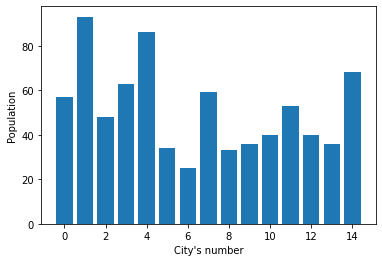

In [16]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)
cities = np.random.randint(10, 100, 15)

plt.bar(np.arange(len(cities)), cities)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

На гистограмму выше нужно смотреть как на распределение, из которого мы хотим научиться моделировать случайные величины. 

Задаем функцию, которая определяет номер следующего города, куда отправляется кандитат (возможно, остается в текущем городе). Для простоты будем перемещаться только в города с номерами на 1 больше или меньше, чем текущий:

In [17]:
def step(current, cities):
    direction = np.random.choice([-1, 1])
    target = (current + direction) % len(cities)
    ratio = cities[target] / cities[current]
    return target if np.random.rand() < ratio else current

Моделируем перемещения кандитата за период 10000 дней:

In [18]:
walk = []
current = 1 # стартуем из города с номером 1
for i in range(10000):
    current = step(current, cities)
    walk.append(current)

Рисуем гистограмму распределения доли времени, проведенного в каждом городе:

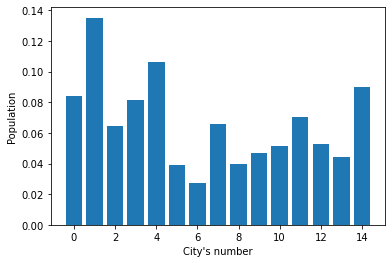

In [19]:
plt.hist(walk, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

Полученная гистограмма почти не отличается от гистограммы, задающей распределения числа жителей по городам. Таким образом, массив ```walk``` можно рассматривать как выборку из данного распределения, а предложенный процесс обхода городов - как генератор случайных чисел из этого распределения. 

Несколько замечаний:
* Полезно отбросить начальный кусок массива ```walk```, пока последовательность не вышла на стационарный режим
* В нашей реализации соседные элементы массива ```walk``` сильно скоррелированы (по определению, они отличаются не более чем на 1). Поэтому полезно проредить ряд, например, рассматривать каждый сотый элемент, и это даст выборку из почти независимых величин.

Общая идея MCMC:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Алгоритм Metropolis sampling:
* пусть $\pi$ - заданное распределение (не обязательно нормированное к 1) на множестве $\Omega$
* пусть $Q = (q_{i, j})$ - матрица переходных вероятностей произвольной эргодической цепи Маркова с состояниями из $\Omega$
* выберем произвольное $X_0$ из $\Omega$
* для текущего $X_n$ смоделируем значение $Z_{n+1}$ из распределения $q_{X_n, \cdot}$
* смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi_i q_{i, j}}{\pi_j q_{j, i}} )
$$
* если $\alpha$ = 1, то $X_{n+1} = Z_{n+1}$, иначе $X_{n+1} = X_{n}$.

Реализуем алгоритм Metropolis sampling. Функция `metroplis` принимает на вход
* начальное состояние цепи Маркова (`start`)
* функцию, вычисляющую значение плотности в произвольной точке (функция `value`)
* функцию, предлагающую выбор нового состояния (функция `proposal`)
* количество итераций (`niter`)

In [20]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.

    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

В приложение к предыдущей задаче вот как определяются `value` и `proposal` и как выглядит гистограмма, полученная по смоделированной выборке:

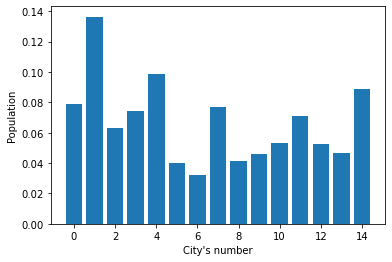

In [21]:
value = lambda x: cities[x]
proposal = lambda x: (x + np.random.choice([-1, 1])) % len(cities)
post = metroplis(1, value, proposal, 10000)

plt.hist(post, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

---

**Задание 4.** Примените алгоритм Metropolis для генерации выборки из смеси двух гауссиан. Плотность смеси задается в виде 
p(x) = 0.3N(-4, 2) + 0.7N(3, 6), где N(a, b) - плотность нормального распределения со средним a и дисперсией b. Для наглядности, ниже приведен график плотности смеси. Покажите, что гистограмма, построенная по выборке, приближает заданную плотность смеси.

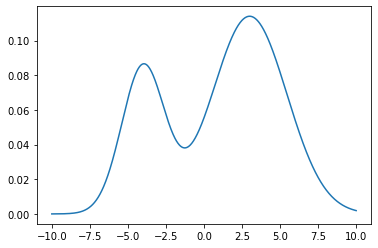

In [22]:
from scipy.stats import norm
import scipy.stats as sps

x = np.linspace(-10, 10, 1000)
y = 0.3*norm(-4, np.sqrt(2)).pdf(x) + 0.7*norm(3, np.sqrt(6)).pdf(x)

plt.plot(x, y)

plt.show()

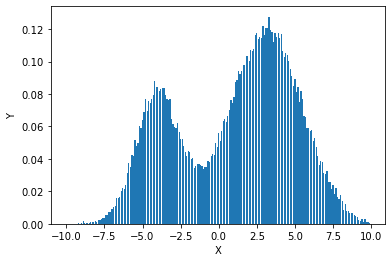

In [66]:
import scipy.stats as sps
from math import sqrt

def normal(E, D, x):
    return 1/(sqrt(2*D*np.pi))*np.exp(-(x-E)**2/(2*D))

def mixture(point, **kwargs):
    return 0.3*normal(-4, 2, point) + 0.7*normal(3, 6, point)

def proposal(curr, **kwargs):
    res = curr + 0.1*np.random.choice(np.arange(19)-9)
    
    if (res < -10):
        res = res + 20
        
    if (curr > 10):
        res = res - 20
        
    return res

Y = metroplis(0, value, proposal, 100000)

plt.hist(Y, bins = np.arange(201)/10 - 10.05, rwidth = 0.8, density=True)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

Похожи!!!

## Литература

*  http://probability.ca/jeff/ftpdir/johannes.pdf
* http://nitro.biosci.arizona.edu/courses/EEB596/handouts/Gibbs.pdf
